In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [7]:
# Load datasets
features_df = pd.read_csv(r'C:\Users\bhavy\Desktop\Walmart Data\features.csv')
stores_df = pd.read_csv(r'C:\Users\bhavy\Desktop\Walmart Data\stores.csv')
train_df = pd.read_csv(r'C:\Users\bhavy\Desktop\Walmart Data\train.csv')
test_df = pd.read_csv(r'C:\Users\bhavy\Desktop\Walmart Data\test.csv')


In [8]:
# Convert Date column to datetime format
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])
features_df['Date'] = pd.to_datetime(features_df['Date'])


In [9]:
# Merge datasets
train_df = train_df.merge(stores_df, on='Store', how='left')
train_df = train_df.merge(features_df, on=['Store', 'Date'], how='left')

test_df = test_df.merge(stores_df, on='Store', how='left')
test_df = test_df.merge(features_df, on=['Store', 'Date'], how='left')

In [10]:
# Fill missing values
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

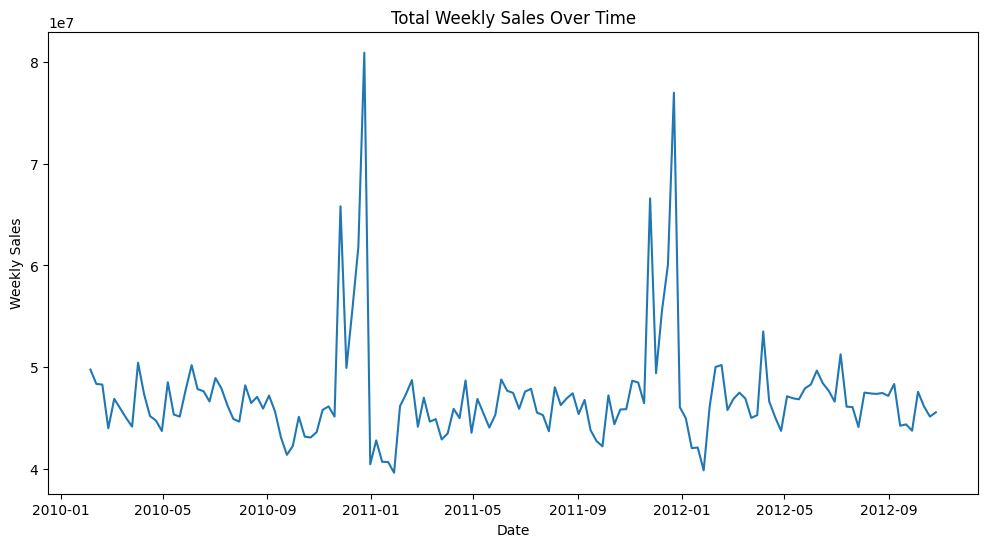

In [11]:
# Exploratory Data Analysis
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_df.groupby('Date')['Weekly_Sales'].sum())
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

In [12]:
# Model Training: SARIMA
sarima_model = SARIMAX(train_df.groupby('Date')['Weekly_Sales'].sum(), order=(1,1,1), seasonal_order=(1,1,1,52))
sarima_results = sarima_model.fit()
train_df['SARIMA_Forecast'] = sarima_results.predict()


C:\Users\bhavy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\bhavy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\bhavy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [13]:
# Model Training: Prophet
prophet_df = train_df[['Date', 'Weekly_Sales']].rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=90)
forecast = prophet_model.predict(future)

21:17:14 - cmdstanpy - INFO - Chain [1] start processing
21:17:21 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
# Machine Learning Approach
X = train_df[['Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]
y = train_df['Weekly_Sales']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_val)

In [15]:
# Model Evaluation
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
print(f'MAE: {mae}, MSE: {mse}')


MAE: 1948.9165532414543, MSE: 34846611.96324472


In [16]:
# Predict on test data
test_df['Predicted_Sales'] = rf_model.predict(test_df[['Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']])

# Save Predictions
test_df[['Store', 'Dept', 'Date', 'Predicted_Sales']].to_csv('sales_predictions.csv', index=False)


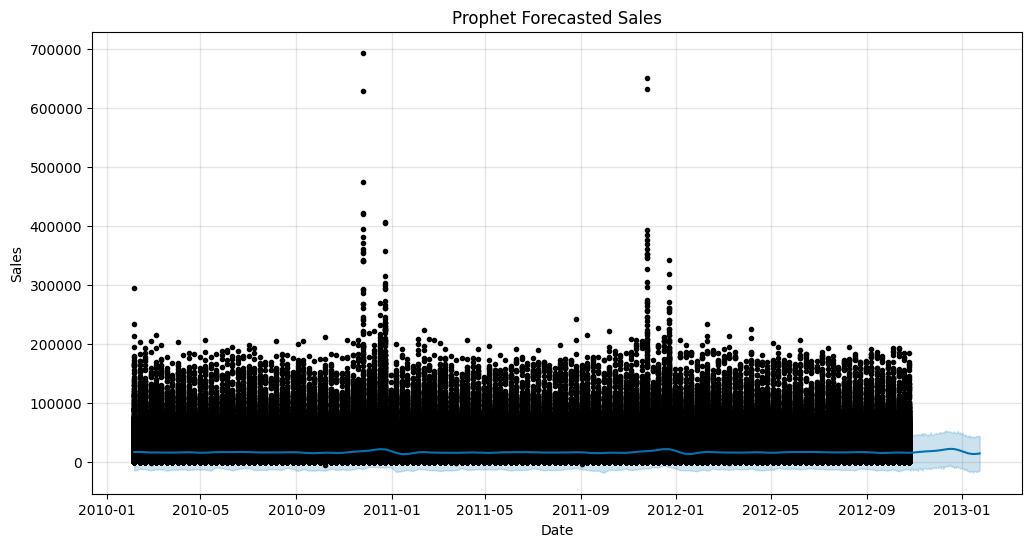

In [22]:
import matplotlib.pyplot as plt

# Plot Prophet Forecast using Matplotlib
fig, ax = plt.subplots(figsize=(12, 6))
prophet_model.plot(forecast, ax=ax)
ax.set_title("Prophet Forecasted Sales")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
plt.show()
